In [3]:
import numpy as np
import os
from dotenv import load_dotenv
load_dotenv()
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
import nibabel as nib
import subprocess
import hcp_utils
import seaborn as sns
from nilearn.image import clean_img
import matplotlib.pyplot as plt
from tqdm import tqdm
from nilearn import plotting
from scipy import stats


### preocess timeseries data (e.g., resting state) by low and high pass filtering and confound regression
### uses code from ciftify: https://github.com/edickie/ciftify/blob/master/ciftify/bin/ciftify_clean_img.py#L331
### visualizes resting state timeseries in an example ROI before and after cleaning

In [4]:
#define subject and session
subject="sub-01"
session="ses-01"
run = 1
start_from_TR = 0 #in case you have dummy TRs in the beginning
TR_acq=1.75

#setup paths
datasets_root = os.getenv("DATASETS_ROOT")
dataset_root = os.path.join(datasets_root,"BOLDMomentsDataset") 
project_root = os.getenv("PROJECT_ROOT") 

if datasets_root is None:
    raise EnvironmentError(f"The environment variable 'DATASETS_ROOT' is not defined.")
if project_root is None:
    raise EnvironmentError(f"The environment variable 'PROJECT_ROOT' is not defined.")

fmri_output_path = os.path.join(dataset_root, "derivatives", "versionC", "timeseries_processing", subject, session)
if not os.path.exists(fmri_output_path ):
    os.makedirs(fmri_output_path )

In [5]:
#setup ROI selection
roi_selection = ['IPS1']
groups = list(np.arange(1,23)) #[1,2,3,4,5,6,7,8,9,15,16,17,18] #groups from the glasser parcellation I want. see table 1 in glasser supplementary for details
tmp = pd.read_table(os.path.join(project_root, "assets","hcp_glasser_roilist.txt"), sep=',')
roi_idx_running = {} #get the cifti indices for all rois
for count in range(tmp.shape[0]):
    line = tmp.iloc[count,:]
    ROI = line['ROI']
    GROUP = line['GROUP']
    ID = line['ID']
    if GROUP in groups: #if the roi is in a group we want, include that roi
        roi_idx_running[ROI] = np.where(((hcp_utils.mmp.map_all == ID)) | (hcp_utils.mmp.map_all == ID+180))[0]

if roi_selection[0] == 'all':
    rois = list(roi_idx_running.keys())
else:
    rois = roi_selection
    for roi in rois:
        if roi not in roi_idx_running:
            raise ValueError(f"ROI {roi} you specified is not one of the Glasser Atlas ROIs")
        
roi_selected_indices = []
roi_selected_indices.extend([roi_idx_running[roi] for roi in rois])

In [6]:
#load nuissance regressors
COI = ['trans_x','trans_x_derivative1', 'trans_x_power2', 'trans_x_derivative1_power2',
       'trans_y', 'trans_y_derivative1', 'trans_y_power2', 'trans_y_derivative1_power2',
       'trans_z', 'trans_z_derivative1', 'trans_z_power2', 'trans_z_derivative1_power2',
       'rot_x', 'rot_x_derivative1', 'rot_x_power2', 'rot_x_derivative1_power2',
       'rot_y', 'rot_y_derivative1', 'rot_y_power2', 'rot_y_derivative1_power2',
       'rot_z', 'rot_z_derivative1', 'rot_z_power2', 'rot_z_derivative1_power2'] #confounds of interest to include. HCP resting state: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3720828/ and https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3811142/
confounds = pd.read_table(os.path.join(dataset_root, "derivatives", "versionC", "fmriprep", subject, session, "func", f"{subject}_{session}_task-rest_run-{run}_desc-confounds_timeseries.tsv"))
confounds_select = confounds.loc[:,COI] #(numscans_interp, numregressors)
motion_regressors = np.array(confounds_select)
if (~np.isfinite(motion_regressors)).sum() > 0:
    motion_regressors[~np.isfinite(motion_regressors)] = 0 #fill nans or infs with 0

(212, 91282)
(212,)


Text(0.5, 1.0, 'unprocessed resting state averaged over IPS1 vertices')

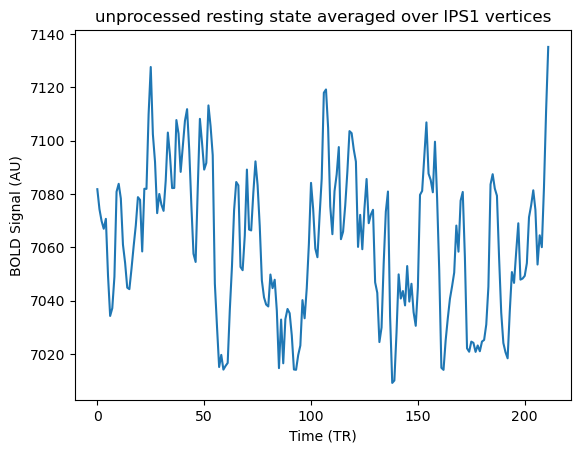

In [7]:
#path to resting state file output from fmriprep
func_root = os.path.join(dataset_root, 'derivatives', "versionC", 'fmriprep', subject, session, 'func')
cifti_rest_path = os.path.join(func_root, f'{subject}_{session}_task-rest_run-{run}_space-fsLR_den-91k_bold.dtseries.nii')
cifti_rest = nib.load(cifti_rest_path).get_fdata()
print(cifti_rest.shape)

data = np.mean(cifti_rest[:,roi_selected_indices[0]],axis=1) #average over indices
print(data.shape)
sns.lineplot(data)
plt.xlabel("Time (TR)")
plt.ylabel("BOLD Signal (AU)")
plt.title(f"unprocessed resting state averaged over {roi_selection[0]} vertices")

In [8]:
#seed analysis of unclean data
seed = np.mean(cifti_rest[:,roi_selected_indices[0]], axis=1)
ntime, nvertices = cifti_rest.shape
rs_connectivity = np.zeros((nvertices,))
for v in tqdm(range(nvertices)):
    rs_connectivity[v] = stats.pearsonr(seed, cifti_rest[:, v])[0]

100%|██████████| 91282/91282 [01:18<00:00, 1168.66it/s]


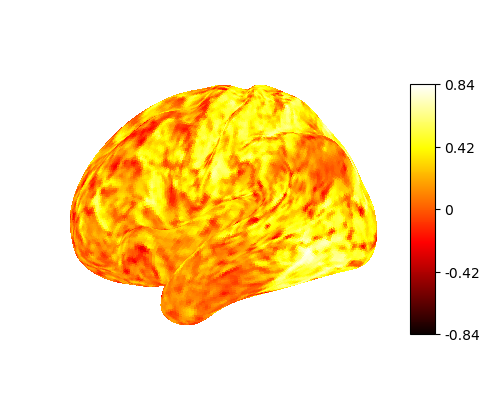

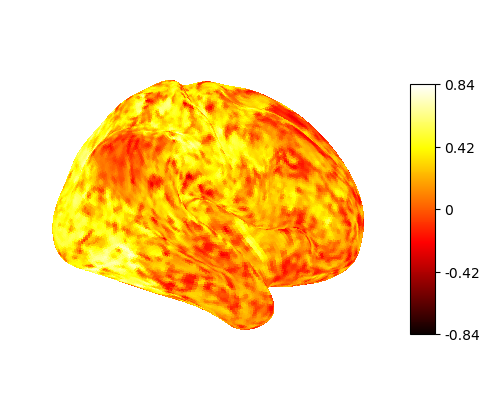

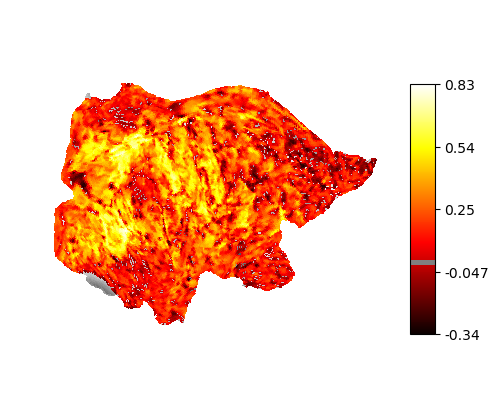

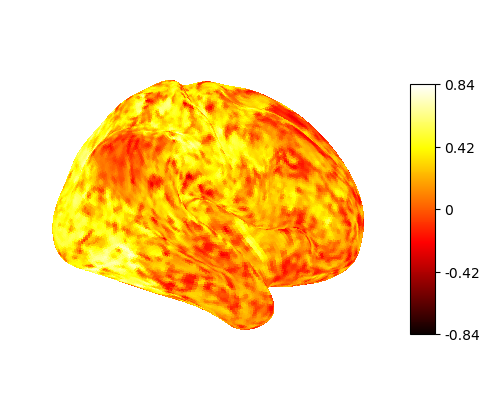

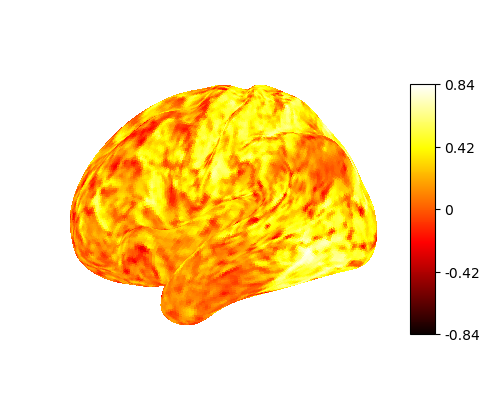

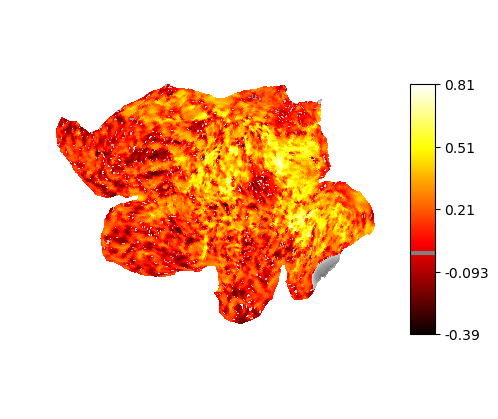

In [9]:
views = ['lateral', 'medial'] #['lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior']
stat = rs_connectivity
for hemi in ['left','right']:

    mesh = hcp_utils.mesh.inflated
    cortex_data = hcp_utils.cortex_data(stat)
    bg = hcp_utils.mesh.sulc
    for view in views:
        display = plotting.plot_surf_stat_map(mesh, cortex_data, hemi=hemi,
        threshold=0, bg_map=bg, view=view, cmap='hot')
        plt.show()

    #flattened brain
    if hemi == 'left':
        cortex_data = hcp_utils.left_cortex_data(stat)
        display = plotting.plot_surf(hcp_utils.mesh.flat_left, cortex_data,
        threshold=0.01, bg_map=hcp_utils.mesh.sulc_left, colorbar=True, cmap='hot')
        plt.show()

    if hemi == 'right':
        cortex_data = hcp_utils.right_cortex_data(stat)
        display = plotting.plot_surf(hcp_utils.mesh.flat_right, cortex_data,
        threshold=0.01, bg_map=hcp_utils.mesh.sulc_right, colorbar=True, cmap='hot')
        plt.show()

In [15]:
cifti_rest_clean_path = os.path.join(fmri_output_path, f'{subject}_{session}_task-rest_run-{run}_space-fsLR_den-91k_bold_clean.dtseries.nii')

tmpdir = os.path.join(fmri_output_path, "tmp")
input_nifti = os.path.join(tmpdir,'func_fnifti.nii.gz') #create a fake nifti
cmd = f"wb_command -cifti-convert -to-nifti -smaller-dims \
    {cifti_rest_path} \
    {input_nifti}"
if not os.path.isfile(cifti_rest_clean_path):
    print(f"converting cifti run {run}")
    if not os.path.exists(tmpdir):
        os.makedirs(tmpdir)
    subprocess.run(cmd, shell=True, check=True)

converting cifti run 1


In [16]:
#index non-dummy TRs
nib_image = nib.load(input_nifti)
trimmed_nifti = nib_image.slicer[:,:,:, start_from_TR:]

#clean the data using nilearn
clean_output = clean_img(trimmed_nifti, detrent=True, standardize=True, confounds=motion_regressors, high_pass=0.008, t_r=TR_acq, ensure_finite=False) #no low pass, like in HCP. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3811142/
clean_output_nifti = os.path.join(tmpdir, 'clean_fnifti.nii.gz')
clean_output.to_filename(clean_output_nifti)


In [17]:

cifti_rest_clean_path = os.path.join(fmri_output_path, f'{subject}_{session}_task-rest_run-{run}_space-fsLR_den-91k_bold_clean.dtseries.nii')

"""
documentation: https://www.humanconnectome.org/software/workbench-command/-cifti-convert
nifti-in: our input nifti file that has been cleaned and saved to a tmp file called 'clean_fnifti.nii.gz'
cifti-template: our original cifti file for the data that we now use as a template
cifti-out: path and filename for the new saved nifti file

"""

cmd = f"wb_command -cifti-convert -from-nifti \
    {clean_output_nifti} \
    {cifti_rest_path} \
    {cifti_rest_clean_path} \
    '-reset-timepoints' \
    {TR_acq} \
    {start_from_TR}"

if not os.path.isfile(cifti_rest_clean_path):
    print(f"converting from clean nifti to clean cifti for run {run}")
    subprocess.run(cmd, shell=True, check=True)

converting from clean nifti to clean cifti for run 1


(212, 91282)
(212,)


Text(0.5, 1.0, 'cleaned resting state averaged over IPS1 vertices')

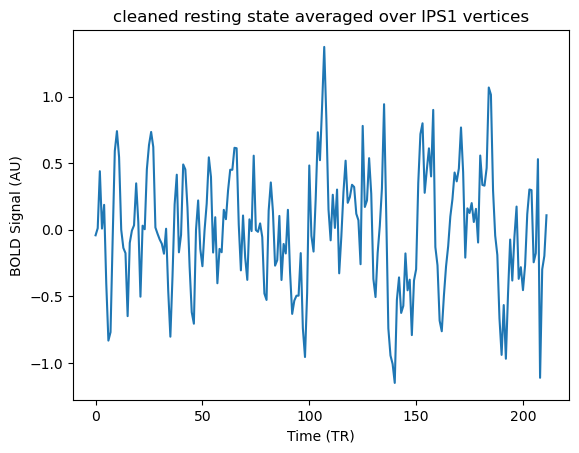

In [18]:
#path to resting state file output from fmriprep
cifti_rest_clean = nib.load(cifti_rest_clean_path).get_fdata()
print(cifti_rest_clean.shape)

data = np.mean(cifti_rest_clean[:,roi_selected_indices[0]],axis=1) #average over indices
print(data.shape)
sns.lineplot(data)
plt.xlabel("Time (TR)")
plt.ylabel("BOLD Signal (AU)")
plt.title(f"cleaned resting state averaged over {roi_selection[0]} vertices")

In [19]:
#seed analysis
seed = np.mean(cifti_rest_clean[:,roi_selected_indices[0]], axis=1)
ntime, nvertices = cifti_rest_clean.shape
rs_connectivity = np.zeros((nvertices,))
for v in tqdm(range(nvertices)):
    rs_connectivity[v] = stats.pearsonr(seed, cifti_rest_clean[:, v])[0]

100%|██████████| 91282/91282 [02:05<00:00, 725.63it/s] 


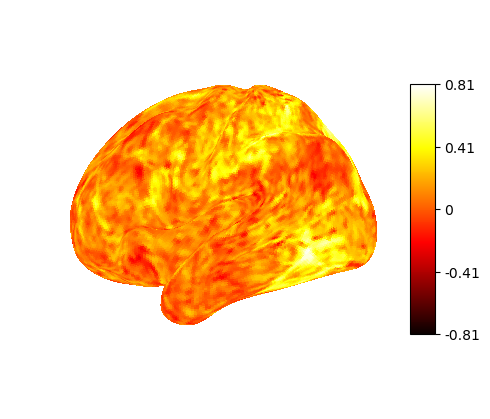

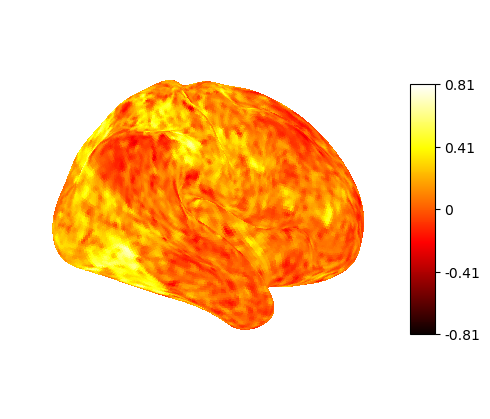

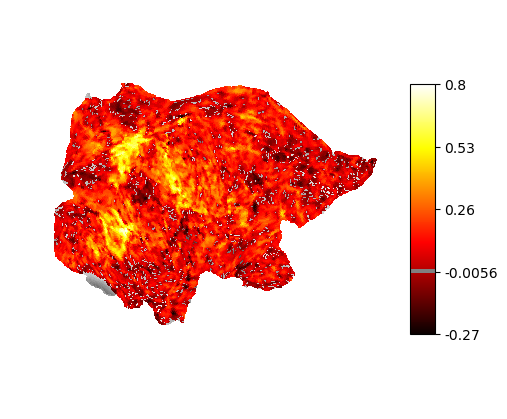

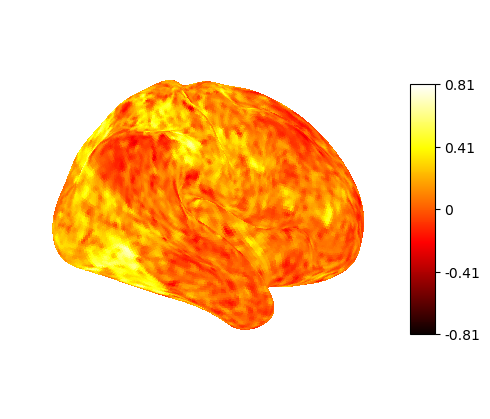

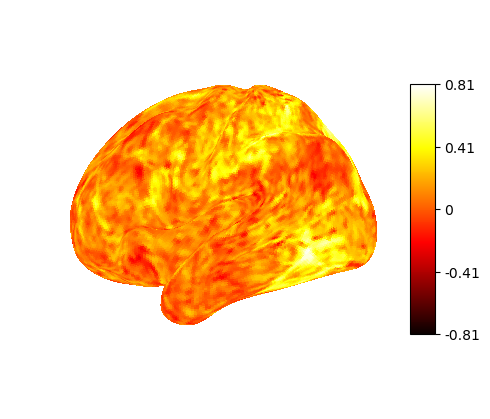

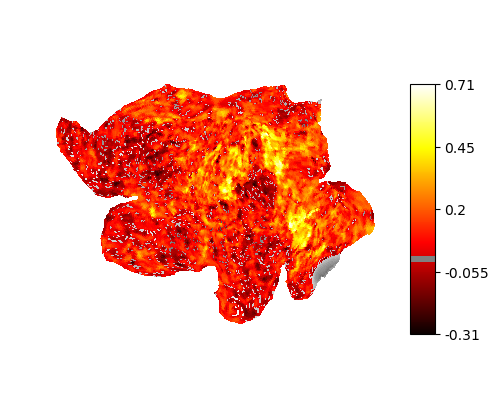

In [20]:
views = ['lateral', 'medial'] #['lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior']
stat = rs_connectivity
for hemi in ['left','right']:

    mesh = hcp_utils.mesh.inflated
    cortex_data = hcp_utils.cortex_data(stat)
    bg = hcp_utils.mesh.sulc
    for view in views:
        display = plotting.plot_surf_stat_map(mesh, cortex_data, hemi=hemi,
        threshold=0, bg_map=bg, view=view, cmap='hot')
        plt.show()

    #flattened brain
    if hemi == 'left':
        cortex_data = hcp_utils.left_cortex_data(stat)
        display = plotting.plot_surf(hcp_utils.mesh.flat_left, cortex_data,
        threshold=0.01, bg_map=hcp_utils.mesh.sulc_left, colorbar=True, cmap='hot')
        plt.show()

    if hemi == 'right':
        cortex_data = hcp_utils.right_cortex_data(stat)
        display = plotting.plot_surf(hcp_utils.mesh.flat_right, cortex_data,
        threshold=0.01, bg_map=hcp_utils.mesh.sulc_right, colorbar=True, cmap='hot')
        plt.show()